# Set up
Add shortcut of the shared folder to "My Drive" to mount successfully.

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CS230_Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))



Mounted at /content/drive


In [2]:
!pip install basemap

     |████████████████████████████████| 862 kB 4.2 MB/s 
     |████████████████████████████████| 30.5 MB 1.2 MB/s 
     |████████████████████████████████| 219 kB 29.1 MB/s 
     |████████████████████████████████| 6.3 MB 29.6 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=80ff3b3ae86ac2db1bced8fc0a9e25fa46be932a55b54b2ea55dd0249f45ce0d
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
from torch.nn.modules.activation import CELU
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
from tqdm import tqdm
import pandas as pd
import logging
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, LSTM, TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import Callback


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from os import listdir

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 200
print('using device:', device)

using device: cuda


# Part I. Uploading the Dataset

In [5]:
city_info = pd.read_csv('/content/drive/My Drive/CS230_Project/Dataset/7890488/city_info.csv')
N = len(city_info)
city_info.iloc[:10]

,Unnamed: 0,Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate
0,1,Lander,USW00024021,42.8153,-108.7261,LANDER WBO,1892-01-01,1946-05-28
1,2,Lander,USW00024021,42.8153,-108.7261,LANDER HUNT FIELD,1946-05-29,2021-12-31
2,3,Cheyenne,USW00024018,41.1519,-104.8061,CHEYENNE WBO,1871-01-01,1935-08-31
3,4,Cheyenne,USW00024018,41.1519,-104.8061,CHEYENNE MUNICIPAL ARPT,1935-09-01,2021-12-31
4,5,Wausau,USW00014897,44.9258,-89.6256,Wausau Record Herald,1896-01-01,1941-12-31
5,6,Wausau,USW00014897,44.9258,-89.6256,Wausau Airport,1942-01-01,2021-12-31
6,7,Hayward,USW00094973,46.0261,-91.4442,Hayward RS,1894-01-01,1998-03-31
7,8,Hayward,USW00094973,46.0261,-91.4442,Hayward Muni AP,1998-04-01,2021-12-31
8,9,EauClaire,USW00014991,44.8664,-91.4878,Eau Claire City,1893-01-01,1949-09-30
9,10,EauClaire,USW00014991,44.8664,-91.4878,Eau Claire Chippewa Valley Regional Airport,1949-10-01,2021-12-31


In [6]:
#Given the city_id, return the city_data dataframe and city_name
def get_city_info(city_id):
  
  city_id_csv = city_id + '.csv'
  city_data = pd.read_csv('/content/drive/My Drive/CS230_Project/Dataset/7890488/{}'.format(city_id_csv))
  tmax = city_data.iloc[[1]]['tmax']
  for i in range(len(city_info)):
    if city_info.iloc[:]['ID'].str.find(city_id)[i] == 0:
      city_name_idx = i
  city_name = city_info.iloc[city_name_idx]['Name']
  city_lat = city_info.iloc[city_name_idx]['Lat']
  city_lon = city_info.iloc[city_name_idx]['Lon']
  return city_data, city_name, city_lat, city_lon

#Calculate daily average T of given city data
def averageT_list(city_data):
  taverage = []
  n = len(city_data)
  for i in range(n):
    tmax = city_data.iloc[i]['tmax']
    tmin = city_data.iloc[i]['tmin']
    taverage.append(round((tmax + tmin)/2, 2))
  return taverage

def averageT(city_data):
  taverage = 0
  n = len(city_data)
  tmax_mean = np.mean(city_data.iloc[:]['tmax'])
  tmin_mean = np.mean(city_data.iloc[:]['tmin'])
  taverage += round((tmax_mean + tmin_mean)/2, 2)
  return taverage

def plot_city_data(city_data):
  plt.plot(city_data)
  plt.ylabel('Temperature')
  plt.xlabel('Time')
  plt.ylim([-150,250])
  plt.show()

def plot_city_color(city_data):
  colors = city_data[:3000]
  t = range(3000)
  plt.scatter(t,city_data[:3000],c=colors)
  plt.show()

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [7]:
city_id = city_info.iloc[0]['ID']
city_data, city_name, city_lat, city_long = get_city_info(city_id)
#city_average_T_list = averageT_list(city_data)
city_average_T = averageT(city_data)

#plot_city_data(city_average_T_list)
#plot_city_color(city_average_T_list)


In [8]:
#Calculate average temp and transfer from F to C
temp_list = []
for i in range(N):
  city_id = city_info.iloc[i]['ID'] 
  city_data, city_name, city_lat, city_long = get_city_info(city_id)
  city_average_T = averageT(city_data)
  city_average_T_C = 5/9 * (city_average_T-32)
  temp_list.append(city_average_T_C)


In [9]:
#Get other information about the city
lat_list = city_info.iloc[:]['Lat'].tolist()
lon_list = city_info.iloc[:]['Lon'].tolist()
id_list = city_info.iloc[:]['ID'].tolist()
name_list = city_info.iloc[:]['Name'].tolist()

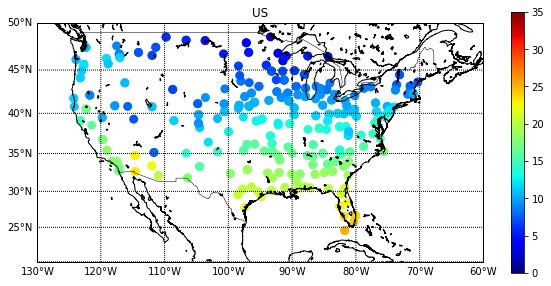

In [10]:
plt.figure(figsize=(10,8))
m = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')
m.drawcoastlines()
m.drawcountries()
# draw parallels and meridians.
parallels = np.arange(-90.,91.,5.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,10.)
m.drawmeridians(meridians,labels=[True,False,False,True])
m.drawmapboundary(fill_color='white')
plt.title("US")
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon_list, lat_list)
# Color the points, s changes the marker sizes.
sc = plt.scatter(x,y, c=temp_list, vmin=0, vmax =35, cmap=jet, s=80, edgecolors='none')
# Include that colorbar
cbar = plt.colorbar(sc, shrink = .6)
plt.show()



# RNN Model

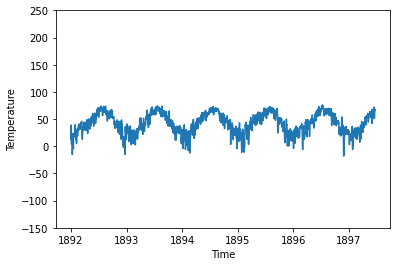

In [11]:
city_data = 0
city_id = city_info.iloc[0]['ID']
city_data, city_name, city_lat, city_long = get_city_info(city_id)
city_data = city_data.dropna()

#test = datetime.strptime(city_data['Date'][0], '%Y-%m-%d')
#test1 = pd.to_datetime(city_data['Date'])
#city_data['Date'] = pd.to_datetime(city_data['Date'])
city_data['average_T'] = (city_data['tmax'] + city_data['tmin'])/2
temp_data = city_data[['Date', 'average_T']]


city_data = city_data.set_index(['Date'])
city_data.index = pd.to_datetime(city_data.index)
if not city_data.index.is_monotonic:
    city_data = city_data.sort_index()

plot_city_data(city_data['average_T'][:2000])

In [12]:
print(temp_data.shape)
temp_data

(47117, 2)


,Date,average_T
0,1892-01-01,13.50
1,1892-01-02,20.00
2,1892-01-03,33.00
3,1892-01-04,39.00
4,1892-01-05,15.50
...,...,...
47477,2021-12-27,26.05
47478,2021-12-28,13.20
47479,2021-12-29,15.15
47480,2021-12-30,26.10


In [13]:
print("How many NaN are there in the temperature dataset?",temp_data.isna().sum())

How many NaN are there in the temperature dataset? Date         0
average_T    0
dtype: int64


In [14]:
#Train with first 10000 data
Tp = 10000
step = 8
batch_size=8
num_epochs = 1000

In [15]:
train = np.array(temp_data['average_T'][:Tp])
test = np.array(temp_data['average_T'][Tp:])
print("Train data length:", train.shape)
print("Test data length:", test.shape)
train=train.reshape(-1,1)
test=test.reshape(-1,1)

Train data length: (10000,)
Test data length: (37117,)


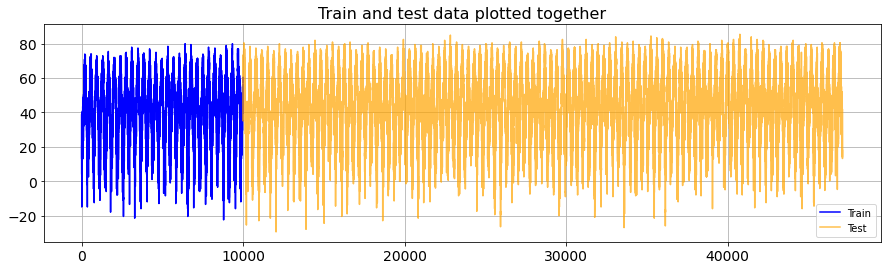

In [16]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together",fontsize=16)
plt.plot(np.arange(Tp),train,c='blue')
plt.plot(np.arange(Tp, 47117),test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Here, we choose step=8. In more complex RNN and in particular for text processing, this is also called embedding size. The idea here is that we are assuming that 8 hours of weather data can effectively predict the 9th hour data, and so on.


In [17]:
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (10008,)
Test data length: (37125,)


# Converting to a multi-dimensional array

Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [18]:
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (10000, 1, 8) ,  (10000,)
Test data shape: (37117, 1, 8) ,  (37117,)


# Modeling
Keras model with SimpleRNN layer

We build a simple function to define the RNN model. It uses a single neuron for the output layer because we are predicting a real-valued number here. As activation, it uses the ReLU function. Following arguments are supported.

neurons in the RNN layer
embedding length (i.e. the step length we chose)
nenurons in the densely connected layer
learning rate

In [19]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [20]:
def build_seq2seq_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a seq2seq RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), return_sequences = True))
    model.add(SimpleRNN(units=num_units, return_sequences = True))
    model.add(SimpleRNN(units=num_units, return_sequences = False))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [21]:
def build_LSTM_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a LSTM RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1,embedding), return_sequences = True))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [22]:
model_temp = None
model1= build_seq2seq_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)
#model_temp.save('/content/drive/My Drive/CS230_Project')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
model_LSTM = build_LSTM_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [24]:
#model_temp = keras.models.load_model('/content/drive/My Drive/CS230_Project')
model_temp.summary()

AttributeError: ignored

In [25]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            17536     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 128)            32896     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87,489
Trainable params: 87,489
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70144     
                                                                 
 dense_2 (Dense)             (None, 1, 32)             4128      
                                                                 
 dense_3 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 74,305
Trainable params: 74,305
Non-trainable params: 0
_________________________________________________________________


A simple Keras Callback class to print progress of the training at regular epoch interval

Since the RNN training is usually long, we want to see regular updates about epochs finishing. However, we may not want to see this update every epoch as that may flood the output stream. Therefore, we write a simple custom Callback function to print the finishing update every 50th epoch. You can think of adding other bells and whistles to this function to print error and other metrics dynamically.

In [27]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [ ]:
#Train
model_temp.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done


In [28]:
#Train seq2se1 model
seqModel = model1.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)


Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [38]:
model1.save('/content/drive/My Drive/CS230_Project')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CS230_Project/assets


In [30]:
#Train LSTM model
LSTMModel = model_LSTM.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [39]:
model_LSTM.save('/content/drive/My Drive/CS230_Project')

INFO:tensorflow:Assets written to: /content/drive/My Drive/CS230_Project/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/CS230_Project/assets


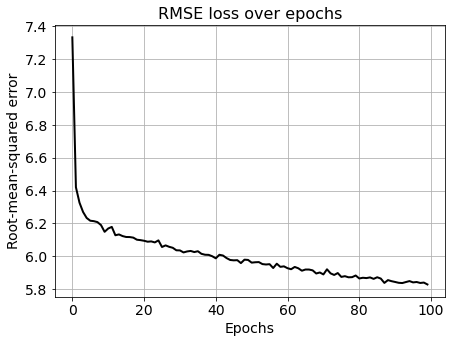

In [ ]:
#simple model
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

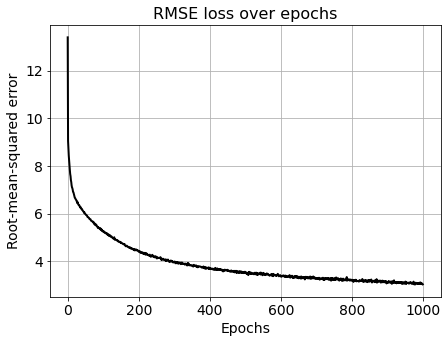

In [29]:
#seq2seq model
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model1.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

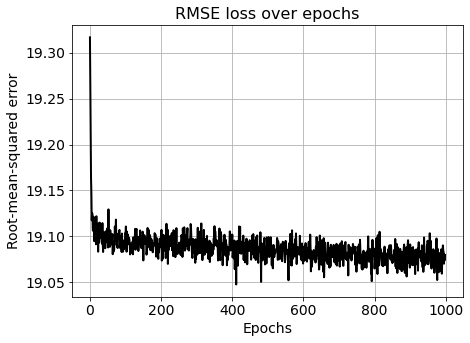

In [36]:
#LSTM model
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_LSTM.history.history['loss'][1:]),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
#Predict
trainPredict = model_temp.predict(trainX)
testPredict= model_temp.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

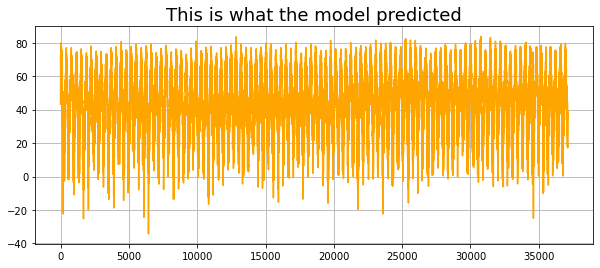

In [ ]:
#Our Prediction
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

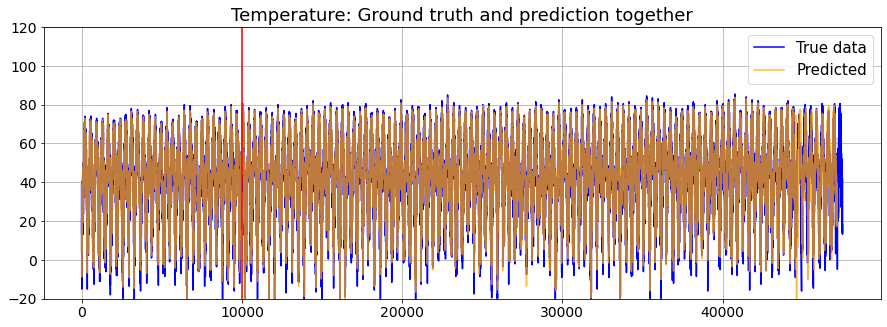

In [ ]:
#Simple model with 100 epoch, Ground truth and prediction together
index = temp_data.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(index,temp_data['average_T'],c='blue')
plt.plot(range(len(predicted)),predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

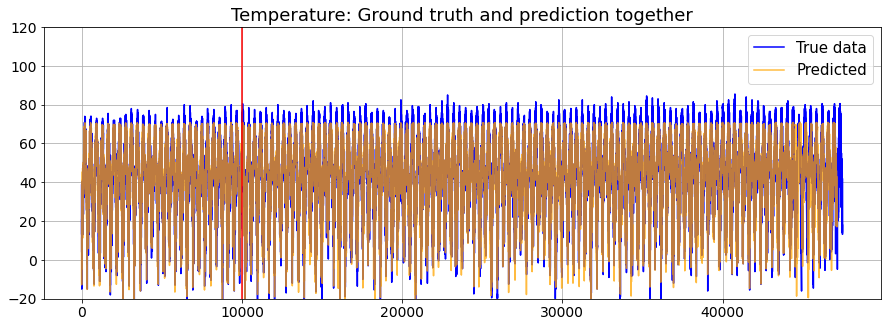

In [ ]:
#Seq2seq model with 100 epoch, Ground truth and prediction together
trainPredict = model1.predict(trainX)
testPredict= model1.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
index = temp_data.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(index,temp_data['average_T'],c='blue')
plt.plot(range(len(predicted)),predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

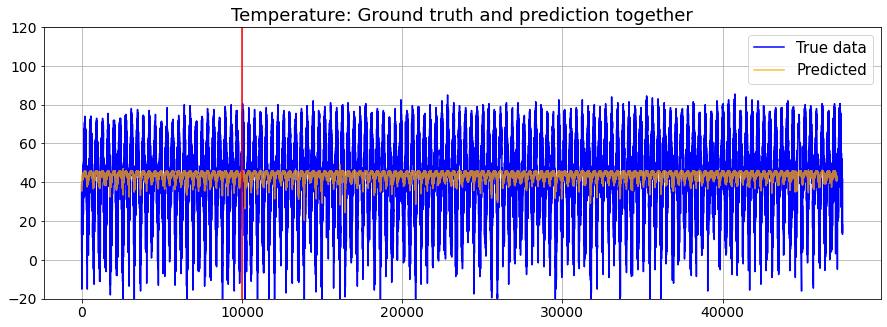

In [ ]:
#LSTM model with 100 epoch, Ground truth and prediction together
trainPredict = model_LSTM.predict(trainX)
testPredict= model_LSTM.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
predicted = predicted.reshape(-1, 1)
index = temp_data.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(index,temp_data['average_T'],c='blue')
plt.plot(range(len(predicted)),predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

Reference： https://colab.research.google.com/drive/1woggle9-TQdCJOAFG0IF1VnkM4GoHz42#scrollTo=e9WjnBr_qLi4